# ANAC


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

#### Seed

In [3]:
seed = 2024
np.random.seed(seed)

In [4]:
diet_csv = pd.read_csv("diet.csv").copy()
recipes_csv = pd.read_csv("recipes.csv").copy()
requests_csv = pd.read_csv("requests.csv").copy()
reviews_csv = pd.read_csv("reviews.csv").copy()

/var/folders/z0/24mzs0z565s6qpzztgbdrj780000gn/T/ipykernel_64503/3884275055.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews_csv = pd.read_csv("reviews.csv").copy()


***Join Dataset***

In [5]:
# merge diet + request
request_with_diet = pd.merge(diet_csv, requests_csv, how="inner", on="AuthorId")
# merge diet + request + recipe
request_with_diet_and_recipe = pd.merge(recipes_csv, request_with_diet, how="inner", on="RecipeId")
# merge diet + request + recipe + review
df = pd.merge(reviews_csv, request_with_diet_and_recipe, how="inner", on=["AuthorId", "RecipeId"])
df

,AuthorId,RecipeId,Rating,Like,TestSetId,Name,CookTime,PrepTime,RecipeCategory,RecipeIngredientQuantities,...,RecipeServings,RecipeYield,Diet,Age,Time,HighCalories,HighProtein,LowFat,LowSugar,HighFiber
0,2492191A,33671,2.0,NaN,1.0,"Chorizo, Pepper &amp; Eggplant Pasta Bake",1500,1200,One dish meal,"c(""\""7\"""", ""\""2\"""", ""\""1\"""", ""\""1\"""", ""\""2\"""",...",...,4.0,NaN,Omnivore,19,2698.714376,0.0,Indifferent,1,0,1
1,2002019979A,92647,2.0,NaN,2.0,Pork and Chickpea Chili,1200,1200,Other,"c(""\""1\"""", ""\""2/3\"""", ""\""1\"""", ""\""1\"""", ""\""1\""...",...,6.0,NaN,Omnivore,66,2399.694583,1.0,Indifferent,0,Indifferent,1
2,408594E,161770,NaN,NaN,3.0,Stuffed Zucchini With Sausage,1200,900,Other,"c(""\""4\"""", ""\""1/2\"""", ""\""1/2\"""", ""\""2\"""", ""\""2...",...,4.0,NaN,Omnivore,35,2099.113170,1.0,Indifferent,0,0,1
3,2001625557E,108231,2.0,NaN,4.0,Cream Cheese and Beef Cracker Spread,0,1200,Other,"c(""\""16\"""", ""\""2\"""", ""\""1\"""", ""\""5\"""")",...,NaN,2 cups,Omnivore,76,1199.645575,1.0,Yes,0,0,1
4,2001427116E,71109,NaN,NaN,5.0,Greek Lemon Chicken Kabobs With Mint Marinade,840,1500,Other,"c(""\""4\"""", ""\""1\"""", ""\""1/4\"""", ""\""1\"""", ""\""1\""...",...,4.0,4 Breast halves,Omnivore,56,2341.181827,1.0,Indifferent,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140190,999595E,338070,2.0,False,NaN,Pumpkin Cake Mix Dessert,3000,900,Other,"c(""\""1\"""", ""\""1\"""", ""\""1\"""", ""\""3\"""", ""\""1\"""",...",...,16.0,NaN,Vegetarian,31,3899.421310,0.0,Indifferent,1,Indifferent,0
140191,999774A,29002,2.0,False,NaN,Summer Corkscrew Pasta,1200,1200,Other,"c(""\""1\"""", ""\""8 -10\"""", ""\""3\"""", ""\""1/3\"""", ""\...",...,4.0,NaN,Vegetarian,57,2402.372535,0.0,Indifferent,0,Indifferent,0
140192,999774A,159252,NaN,False,NaN,"Chili, Kaffir Lime and Lemongrass Jelly",4800,1200,Other,"c(""\""12\"""", ""\""5\"""", ""\""2\"""", ""\""2\"""", ""\""4\"""")",...,NaN,4 cups,Vegetarian,57,5999.598903,0.0,Yes,0,0,0
140193,999774A,1171,2.0,True,NaN,Kahlua Hot Chocolate,360,120,Beverages,"c(""\""2\"""", ""\""1/4\"""", ""\""2\"""", ""\""1/4\"""", ""\""2...",...,1.0,2 mugs,Vegetarian,57,480.233207,1.0,Yes,0,0,0


### Data Cleaning

#### Basics

In [6]:
import re
df["RecipeIngredientParts"] = df["RecipeIngredientParts"].str.replace(")", '')
df["RecipeIngredientParts"] = df["RecipeIngredientParts"].str.replace("(", '')
df["RecipeIngredientParts"] = df["RecipeIngredientParts"].str.replace("\"", '')
df["RecipeIngredientParts"] = df["RecipeIngredientParts"].str.replace("\\", '')
df['RecipeIngredientParts'] = df['RecipeIngredientParts'].str.replace('^c', '', regex=True)

# Extract ingredients from the "RecipeIngredientParts" column and concatenate them
all_ingredients = ','.join(df['RecipeIngredientParts'])

# Split the concatenated string into a list of individual ingredients
individual_ingredients = all_ingredients.split(',')

# Convert the list to a set to get distinct ingredients
distinct_ingredients = set(individual_ingredients)

# Convert the set to a list if needed
distinct_ingredients_list = list(distinct_ingredients)

omnivore_list = []
vegan_list = []
vegetarian_list = []
for items in distinct_ingredients_list:
    if str(items).__contains__("meat") | str(items).__contains__("chicken") | str(items).__contains__("lamb") | str(items).__contains__("beef") | str(items).__contains__("pork") | str(items).__contains__("bacon") | str(items).__contains__("fish") | str(items).__contains__("sausage"):
        omnivore_list.append(items)
        distinct_ingredients_list.remove(items)
    elif str(items).__contains__("milk") | str(items).__contains__("cheese") | str(items).__contains__("butter"):
        omnivore_list.append(items)
        vegetarian_list.append(items)
        distinct_ingredients_list.remove(items)

# Print or use the distinct ingredients list as needed
print(distinct_ingredients_list)
print(len(distinct_ingredients_list))

[' parsley sprigs', 'white potatoes', ' sugar-free strawberry gelatin', ' radish sprouts', ' Teriyaki Glaze Sauce', 'madeira wine', ' dried pinto bean', ' 9-inch graham cracker crust', ' anaheim chili', ' hot green chili peppers', ' chai tea teabags', 'non-dairy milk substitute', ' cinnamon stick', 'diced tomatoes with basil oregano and garlic', 'boneless duck breast', ' shell pasta', ' red chicory', ' cumin', 'fresh spinach leaves', ' ranch-style pinto beans', ' garbanzo beans', ' cider', ' lettuce cup', 'fresh chili peppers', ' vanilla beans', ' Dried Fruit Chutney', ' garlic heads', 'canned plum tomatoes', 'lemon juice', ' fresh jalapeno chilies', ' raw beets', ' Stolichnaya raspberry vodka', 'dried porcini mushrooms', 'garlic heads', ' tuna fillets', ' jalapeno chiles', ' dark amber maple syrup', ' diced tomatoes', ' blackberry brandy', 'fingerling potato', ' masa harina flour', 'anaheim chilies', 'yukon gold potatoes', ' solid-pack pumpkin', ' Tahini Dressing', ' \nmayonnaise', ' 

In [7]:
print("Omnivore List:", omnivore_list)
print("Vegetarian List:", vegetarian_list)
print("Vegan List:", vegan_list)

Omnivore List: ['racks of lamb', ' butter lettuce leaf', 'extra-sharp cheddar cheese', ' crayfish tails', ' vegetarian bacon', 'caerphilly cheese', 'lean ground lamb', 'minced beef', ' manchego cheese', ' blue cheese', 'processed cheese', 'fat-free evaporated milk', ' 2% cheddar cheese', ' \ncoconut milk', 'chicken fat', ' Swanson chicken broth', 'part-skim mozzarella cheese', 'frying chicken', 'lean lamb fillets', ' cheshire cheese', ' nonfat vanilla soymilk', ' low-carb milk', '1% fat buttermilk', 'sweet Italian sausage links', ' mild cheddar cheese', 'Cotija cheese', ' lamb racks', 'instant chicken bouillon granules', ' low fat  sweetened condensed milk', ' skinless chicken breast half', ' boneless chicken breast halves', 'boneless beef top sirloin steaks', ' beef broth', ' cod fish fillets', 'chive & onion cream cheese', 'country-style pork ribs', 'manchego cheese', ' chicken liver', ' vanilla-flavored soymilk', 'chicken thigh pieces', 'farmer cheese', ' baby butter beans', ' chick

In [62]:
# Rename AuthorId column
df.rename(columns= {"AuthorId" : "CustomerId"}, inplace=True)

# Change types of Diet & RecipeCategory into category
df["Diet"] = df["Diet"].astype("category")
df["RecipeCategory"] = df["RecipeCategory"].astype("category")

# Change types to boolean
df["HighCalories"] = df["HighCalories"].astype("bool")
df["LowFat"] = df["LowFat"].astype("bool")
df["HighFiber"] = df["HighFiber"].astype("bool")
df["Like"] = df["Like"].astype("boolean")

# Remove NA rows and Rating column
df = df.drop("Rating", axis=1)
df['Diet'].fillna('Vegetarian', inplace=True)

# Map indifferent values for HighProtein and LowSugar
mapping_protein = {'Yes': 'Yes', 'Indifferent': 'Indifferent', 'No': 'No', '0': 'No', '1': 'Yes'}
df["HighProtein"] = df["HighProtein"].map(mapping_protein).astype('category')

mapping_sugar = {'1': 'Yes', 'Indifferent': 'Indifferent', '0': 'No', }
df["LowSugar"] = df["LowSugar"].map(mapping_sugar).astype('category')

# One hot encoding for categorical variables
df = pd.get_dummies(df, columns=["Diet", "RecipeCategory", "HighProtein", "LowSugar"], drop_first=True)

***Split data***

In [63]:
# Split data into train and test set

train_set = df[df["TestSetId"].isna()]
test_set = df[df["TestSetId"].notnull()]

test_set

,CustomerId,RecipeId,Like,TestSetId,Name,CookTime,PrepTime,RecipeIngredientQuantities,RecipeIngredientParts,Calories,...,Diet_Vegan,Diet_Vegetarian,RecipeCategory_Bread,RecipeCategory_Breakfast,RecipeCategory_Lunch,RecipeCategory_One dish meal,RecipeCategory_Other,RecipeCategory_Soup,HighProtein_Yes,LowSugar_No
0,2492191A,33671,<NA>,3.000000e+12,"Chorizo, Pepper &amp; Eggplant Pasta Bake",1500,1200,"c(""\""7\"""", ""\""2\"""", ""\""1\"""", ""\""1\"""", ""\""2\"""",...","c(""\""chorizo sausage\"""", ""\""eggplant\"""", ""\""ga...",876.4,...,False,False,False,False,False,True,False,False,False,True
1,2002019979A,92647,<NA>,2.000000e+00,Pork and Chickpea Chili,1200,1200,"c(""\""1\"""", ""\""2/3\"""", ""\""1\"""", ""\""1\"""", ""\""1\""...","c(""\""ground pork\"""", ""\""scallion\"""", ""\""garlic...",471.7,...,False,False,False,False,False,False,True,False,False,False
2,408594E,161770,<NA>,3.000000e+00,Stuffed Zucchini With Sausage,1200,900,"c(""\""4\"""", ""\""1/2\"""", ""\""1/2\"""", ""\""2\"""", ""\""2...","c(""\""zucchini\"""", ""\""Italian sausage\"""", ""\""ro...",369.0,...,False,False,False,False,False,False,True,False,False,True
3,2001625557E,108231,<NA>,4.000000e+00,Cream Cheese and Beef Cracker Spread,0,1200,"c(""\""16\"""", ""\""2\"""", ""\""1\"""", ""\""5\"""")","c(""\""cream cheese\"""", ""\""garlic cloves\"""", ""\""...",1278.4,...,False,False,False,False,False,False,True,False,True,True
4,2001427116E,71109,<NA>,5.000000e+00,Greek Lemon Chicken Kabobs With Mint Marinade,840,1500,"c(""\""4\"""", ""\""1\"""", ""\""1/4\"""", ""\""1\"""", ""\""1\""...","c(""\""boneless skinless chicken breast halves\""...",215.3,...,False,False,False,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42809,2000357827D,194823,<NA>,4.281000e+04,Philadelphia Caramel-Pecan Cheesecake,2700,900,"c(""\""1 1/2\"""", ""\""1\"""", ""\""1/4\"""", ""\""4\"""", ""\...","c(""\""pecans\"""", ""\""Philadelphia Cream Cheese\""...",333.3,...,False,True,False,False,False,False,True,False,True,True
42810,2000357827D,35775,<NA>,4.281100e+04,Sweet Dreams Crunch Cherry Dump Cake,3600,300,"c(""\""1\"""", ""\""1\"""", ""\""1/2\"""")","c(""\""cherry pie filling\"""", ""\""lemon juice\"""",...",307.4,...,False,True,False,False,False,False,True,False,False,False
42811,2915363A,26820,<NA>,4.281200e+04,Appetizers-Easy Stuffed Mushrooms,420,2100,"c(""\""8\"""", ""\""3\"""", ""\""1/4\"""", ""\""1/4\"""", ""\""1...","c(""\""fresh mushrooms\"""", ""\""butter\"""", ""\""cele...",81.8,...,False,True,False,False,False,False,True,False,False,True
42812,2001538344B,512974,<NA>,4.281300e+04,"Wild Rice, Brown Rice and Dried Fruit Pilaf",2400,1800,"c(""\""3/4\"""", ""\""3/4\"""", ""\""4\"""", ""\""1/2\"""", ""\...","c(""\""wild rice\"""", ""\""brown rice\"""", ""\""pecans...",198.9,...,False,True,False,False,False,False,True,False,True,True


### Missing values

In [64]:
# diet_csv = diet_csv.dropna(axis="rows") and TestSetId

train_set.dropna(subset=["Like"], inplace=True)
train_set = train_set.drop("TestSetId", axis=1)


C:\Users\Maximilian Mittmann\AppData\Local\Temp\ipykernel_7632\2486316979.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set.dropna(subset=["Like"], inplace=True)


In [65]:
maxtime_val = train_set['Time'].max()
outliers = train_set['Time'] >= maxtime_val
median_without_outliers = train_set.loc[~outliers, 'Time'].median()
train_set.loc[outliers, 'Time'] = median_without_outliers

maxtime_val = train_set['PrepTime'].max()
outliers = train_set['PrepTime'] >= maxtime_val
median_without_outliers = train_set.loc[~outliers, 'PrepTime'].median()
train_set.loc[outliers, 'PrepTime'] = median_without_outliers
outliers = (train_set['Like'] == True) & (train_set['PrepTime'] > 3000000)
train_set.loc[outliers, 'PrepTime'] = median_without_outliers

outliers = (train_set['Like'] == True) & (train_set['Calories'] > 30000)
median_without_outliers = train_set.loc[~outliers, 'Calories'].median()
train_set.loc[outliers, 'Calories'] = median_without_outliers

outliers = train_set['FatContent'] > 25000
median_without_outliers = train_set.loc[~outliers, 'FatContent'].median()
train_set.loc[outliers, 'FatContent'] = median_without_outliers
outliers = (train_set['Like'] == True) & (train_set['FatContent'] > 2500)
train_set.loc[outliers, 'FatContent'] = median_without_outliers

outliers = train_set['SaturatedFatContent'] > 12000
median_without_outliers = train_set.loc[~outliers, 'SaturatedFatContent'].median()
train_set.loc[outliers, 'SaturatedFatContent'] = median_without_outliers

outliers = train_set['CholesterolContent'] > 35000
median_without_outliers = train_set.loc[~outliers, 'CholesterolContent'].median()
train_set.loc[outliers, 'CholesterolContent'] = median_without_outliers
outliers = (train_set['Like'] == True) & (train_set['CholesterolContent'] > 10000)
train_set.loc[outliers, 'CholesterolContent'] = median_without_outliers

outliers = (train_set['Like'] == True) & (train_set['CarbohydrateContent'] > 4000)
median_without_outliers = train_set.loc[~outliers, 'CarbohydrateContent'].median()
train_set.loc[outliers, 'CarbohydrateContent'] = median_without_outliers

outliers = (train_set['Like'] == True) & (train_set['FiberContent'] > 400)
median_without_outliers = train_set.loc[~outliers, 'FiberContent'].median()
train_set.loc[outliers, 'FiberContent'] = median_without_outliers

outliers = (train_set['Like'] == True) & (train_set['SugarContent'] > 4000)
median_without_outliers = train_set.loc[~outliers, 'SugarContent'].median()
train_set.loc[outliers, 'SugarContent'] = median_without_outliers

outliers = train_set['ProteinContent'] > 17500
median_without_outliers = train_set.loc[~outliers, 'ProteinContent'].median()
train_set.loc[outliers, 'ProteinContent'] = median_without_outliers
outliers = (train_set['Like'] == True) & (train_set['ProteinContent'] > 3000)
train_set.loc[outliers, 'ProteinContent'] = median_without_outliers

outliers = train_set['RecipeServings'] > 30000
median_without_outliers = train_set.loc[~outliers, 'RecipeServings'].median()
train_set.loc[outliers, 'RecipeServings'] = median_without_outliers
outliers = (train_set['Like'] == True) & (train_set['RecipeServings'] > 400)
train_set.loc[outliers, 'RecipeServings'] = median_without_outliers

In [66]:
# needs to be done after outlier removal
recipesServings_mean = train_set['RecipeServings'].mean()
#fill na rows with the mean
train_set['RecipeServings'].fillna(recipesServings_mean, inplace=True)
test_set['RecipeServings'].fillna(recipesServings_mean, inplace=True)

C:\Users\Maximilian Mittmann\AppData\Local\Temp\ipykernel_7632\2659033877.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['RecipeServings'].fillna(recipesServings_mean, inplace=True)


In [67]:
# Add additional varibale for difference in requested time and recipe time
train_set["DifferenceRequestedAndTimeNeeded"] = train_set["Time"] - (train_set["CookTime"] + train_set["PrepTime"])
test_set["DifferenceRequestedAndTimeNeeded"] = test_set["Time"] - (test_set["CookTime"] + test_set["PrepTime"])

C:\Users\Maximilian Mittmann\AppData\Local\Temp\ipykernel_7632\2601388586.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set["DifferenceRequestedAndTimeNeeded"] = test_set["Time"] - (test_set["CookTime"] + test_set["PrepTime"])


***Train Model***


In [68]:
variables_to_drop = ['CustomerId', 'RecipeId', 'Like', 'Name', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'RecipeYield', 'RecipeServings']

X = train_set.drop(variables_to_drop, axis=1)
y = train_set['Like']

test_set = test_set.drop(variables_to_drop, axis=1)

In [69]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

saled_df = scaler.fit_transform(X)
saled_df

array([[0.00000000e+00, 2.31481481e-05, 3.95750772e-04, ...,
        0.00000000e+00, 0.00000000e+00, 2.05625311e-03],
       [5.78703704e-05, 1.15740741e-04, 1.12904528e-03, ...,
        1.00000000e+00, 1.00000000e+00, 2.05632278e-03],
       [5.78703704e-06, 5.78703704e-05, 3.58372725e-04, ...,
        1.00000000e+00, 0.00000000e+00, 2.05685526e-03],
       ...,
       [4.62962963e-04, 2.31481481e-04, 2.64784944e-03, ...,
        1.00000000e+00, 1.00000000e+00, 2.05636362e-03],
       [3.47222222e-05, 2.31481481e-05, 1.90000317e-03, ...,
        1.00000000e+00, 1.00000000e+00, 2.05648575e-03],
       [2.60416667e-04, 1.73611111e-04, 5.55820119e-04, ...,
        0.00000000e+00, 0.00000000e+00, 2.05651551e-03]])

In [70]:
transform_scaler = StandardScaler()

scaled_df = transform_scaler.fit_transform(saled_df)
scaled_df

array([[-0.04894697, -0.06219095, -0.25682605, ..., -0.81338387,
        -1.52559654, -0.00574877],
       [-0.04369982, -0.04994256, -0.06601104, ...,  1.2294318 ,
         0.6554813 , -0.00573365],
       [-0.04842226, -0.0575978 , -0.26655242, ...,  1.2294318 ,
        -1.52559654, -0.00561809],
       ...,
       [-0.00696979, -0.03463208,  0.32920619, ...,  1.2294318 ,
         0.6554813 , -0.00572479],
       [-0.04579868, -0.06219095,  0.13460458, ...,  1.2294318 ,
         0.6554813 , -0.00569828],
       [-0.0253348 , -0.04228732, -0.21517344, ..., -0.81338387,
        -1.52559654, -0.00569182]])

In [71]:
X_train, X_test, y_train, y_test = \
    train_test_split(scaled_df, y,
                     test_size=0.3,
                     shuffle=True,
                     random_state=3)

In [168]:
train_model = RandomForestClassifier(n_estimators=100, random_state=seed)

train_model.fit(X_train,y_train)

# Calculate balanced accuracy
pred = train_model.predict(X_test)
score = np.mean(cross_val_score(train_model, X_train, y_train, cv=4, scoring="balanced_accuracy"))
print("Cross validation score for balanced accuracy: " + str(score))

KeyboardInterrupt: 

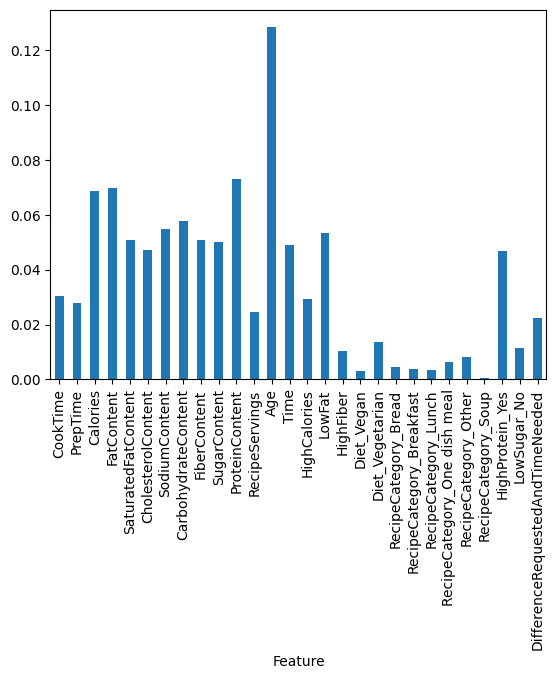

In [130]:
# Plot feature importance 

importance_values = train_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance_values})
imp_plot = importance_df.plot(kind='bar', x='Feature', y='Importance', legend=False)
imp_plot.plot()
plt.show()

***Test Model***

In [131]:
test_predictions = train_model.predict(X_test)
test_probabilities = train_model.predict_proba(X_test)

test_predictions_df = pd.DataFrame({'Like': y_test, 
                                     'Predicted_Like': test_predictions,
                                     'Probability_Like=0': test_probabilities[:, 0],
                                     'Probability_Like=1': test_probabilities[:, 1]})
print(test_predictions_df)


# Confusion Matrix
conf_matrix = confusion_matrix(y_test, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Precision, accuracy, recall
print("Test-Precision:", precision_score(y_test, test_predictions))
print("Test-Accuracy:", accuracy_score(y_test, test_predictions))
print("Test-Recall:", recall_score(y_test, test_predictions))
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test, test_predictions))

        Like  Predicted_Like  Probability_Like=0  Probability_Like=1
20653  False             0.0                0.99                0.01
82063  False             0.0                0.88                0.12
85333  False             0.0                0.95                0.05
96197  False             0.0                0.97                0.03
83016  False             0.0                0.83                0.17
...      ...             ...                 ...                 ...
47865  False             0.0                0.93                0.07
22491   True             0.0                0.90                0.10
10052  False             0.0                1.00                0.00
44580  False             0.0                0.89                0.11
4127   False             0.0                0.96                0.04

[29215 rows x 4 columns]
Confusion Matrix:
[[24797   580]
 [ 2414  1424]]
Test-Precision: 0.7105788423153693
Test-Accuracy: 0.8975183980831765
Test-Recall: 0.3710265763418

***TestSet***

In [72]:
# Gradient Boosting

train_model = GradientBoostingClassifier(n_estimators=300, learning_rate=0.6, random_state=seed)

train_model.fit(X_train,y_train)

score = np.mean(cross_val_score(train_model, X_train, y_train, cv=4, scoring="balanced_accuracy"))
print("Cross validation score for balanced accuracy: " + str(score))

Cross validation score for balanced accuracy: 0.6996236508970365


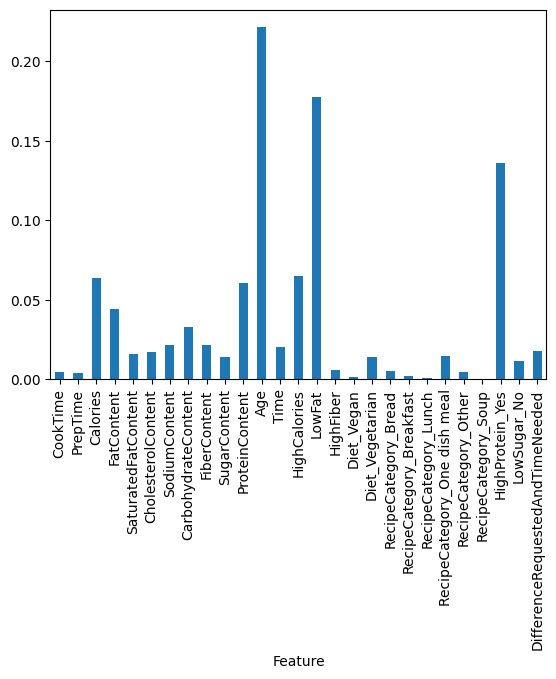

In [73]:
# Plot feature importance 
importance_values = train_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance_values})
imp_plot = importance_df.plot(kind='bar', x='Feature', y='Importance', legend=False)
imp_plot.plot()
plt.show()

In [74]:
test_predictions = train_model.predict(X_test)
test_probabilities = train_model.predict_proba(X_test)

test_predictions_df = pd.DataFrame({'Like': y_test, 
                                     'Predicted_Like': test_predictions,
                                     'Probability_Like=0': test_probabilities[:, 0],
                                     'Probability_Like=1': test_probabilities[:, 1]})
print(test_predictions_df)


# Confusion Matrix
conf_matrix = confusion_matrix(y_test, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Precision, accuracy, recall
print("Test-Precision:", precision_score(y_test, test_predictions))
print("Test-Accuracy:", accuracy_score(y_test, test_predictions))
print("Test-Recall:", recall_score(y_test, test_predictions))
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test, test_predictions))

         Like  Predicted_Like  Probability_Like=0  Probability_Like=1
63467   False             0.0            0.976464            0.023536
124877  False             0.0            0.946770            0.053230
128147  False             0.0            0.996183            0.003817
139011  False             0.0            0.946661            0.053339
125830  False             0.0            0.586847            0.413153
...       ...             ...                 ...                 ...
90679   False             0.0            0.940602            0.059398
65305    True             0.0            0.766861            0.233139
52866   False             0.0            0.991813            0.008187
87394   False             0.0            0.723345            0.276655
46941   False             0.0            0.994901            0.005099

[29215 rows x 4 columns]
Confusion Matrix:
[[24481   896]
 [ 2091  1747]]
Test-Precision: 0.6609912977676883
Test-Accuracy: 0.8977580010268698
Test-Recall: 0.4


#### 1. Logistic Regression
#### 2. Decision Trees
#### 3. Random Forest
#### 4. Naive bayes
#### 5. Gradient Boosting

#### 1. Data Cleaning (missing values, merge tables)
#### 2. Set dataset into training & testing sets + download testing set
#### 3. modeling
#### 4. Model training: train model on training dataset
#### 5. Model evaluation (performance)
#### 6. prediction on the unseen data

***Output file with test set***

In [76]:
test_set["prediction"] = train_model.predict(test_set.drop("TestSetId", axis=1))
test_output = pd.DataFrame(columns=["TestSetId", "prediction"])
test_output["TestSetId"] = test_set["TestSetId"].astype(int)
test_output["prediction"] = test_set["prediction"].astype(int)
test_output.to_csv("predictions_LetsSeePaulAllens'BAC_1.csv", index=False)

c:\users\maximilian mittmann\pycharmprojects\analyticscuptumforrest\venv\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


In [58]:
test_output

,TestSetId,prediction
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1
...,...,...
42809,42810,1
42810,42811,1
42811,42812,0
42812,42813,1
